# K리그 최종 패스 좌표 예측 - EDA (Exploratory Data Analysis)

## 개요
- **목표**: K리그 경기 내 플레이 시퀀스의 마지막 패스 도착 좌표(X,Y) 예측
- **좌표 시스템**: FIFA 공식 권장 경기장 규격 105 x 68 그리드에 매핑된 상대 좌표

## 데이터 구조
- `train.csv`: 학습 데이터 (모든 액션 시퀀스)
- `test.csv`: 평가 데이터 경로
- `test/`: 테스트 데이터 폴더
- `match_info.csv`: 경기 메타데이터
- `sample_submission.csv`: 제출 양식

## 1. 라이브러리 Import 및 설정

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import os
from collections import Counter

# 시각화 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows 한글 폰트
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

# 출력 설정
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

# 경로 설정
DATA_PATH = Path('./open_track1')

print("라이브러리 로드 완료!")

라이브러리 로드 완료!


## 2. 데이터 로드

In [2]:
# 메인 데이터 로드
train_df = pd.read_csv(DATA_PATH / 'train.csv')
test_df = pd.read_csv(DATA_PATH / 'test.csv')
match_info_df = pd.read_csv(DATA_PATH / 'match_info.csv', encoding='utf-8-sig')
sample_submission = pd.read_csv(DATA_PATH / 'sample_submission.csv')

print("✅ 데이터 로드 완료!")
print(f"\n학습 데이터 크기: {train_df.shape}")
print(f"테스트 데이터 크기: {test_df.shape}")
print(f"경기 정보 크기: {match_info_df.shape}")
print(f"제출 양식 크기: {sample_submission.shape}")

✅ 데이터 로드 완료!

학습 데이터 크기: (356721, 15)
테스트 데이터 크기: (2414, 3)
경기 정보 크기: (228, 17)
제출 양식 크기: (2414, 3)


## 3. 기본 데이터 탐색

### 3.1 학습 데이터 (train.csv)

In [3]:
print("=" * 80)
print("학습 데이터 기본 정보")
print("=" * 80)
print("\n[데이터 샘플]")
display(train_df.head(10))

print("\n[컬럼 정보]")
display(train_df.info())

print("\n[기본 통계]")
display(train_df.describe())

학습 데이터 기본 정보

[데이터 샘플]


,game_id,period_id,episode_id,time_seconds,team_id,player_id,action_id,type_name,result_name,start_x,start_y,end_x,end_y,is_home,game_episode
0,126283,1,1,0.667,2354,344559,0,Pass,Successful,52.418205,33.485444,31.322445,38.274752,True,126283_1
1,126283,1,1,3.667,2354,250036,2,Pass,Successful,32.013240,38.100808,37.371285,30.632980,True,126283_1
2,126283,1,1,4.968,2354,500145,4,Carry,NaN,37.371285,30.632980,38.391570,24.613144,True,126283_1
3,126283,1,1,8.200,2354,500145,5,Pass,Successful,38.391570,24.613144,34.573350,5.545468,True,126283_1
4,126283,1,1,11.633,2354,142106,7,Pass,Successful,34.578705,6.058256,21.274470,18.437112,True,126283_1
5,126283,1,1,13.201,2354,500147,9,Carry,NaN,21.274470,18.437112,28.862295,24.320336,True,126283_1
6,126283,1,1,18.900,2354,500147,10,Pass,Successful,28.862295,24.320336,26.569410,35.190204,True,126283_1
7,126283,1,1,19.968,2354,250036,12,Carry,NaN,26.569410,35.190204,35.039130,34.624580,True,126283_1
8,126283,1,1,25.933,2354,250036,13,Pass,Successful,35.039130,34.624580,33.001500,18.885028,True,126283_1
9,126283,1,1,29.767,2354,500147,15,Pass,Successful,35.220780,19.540344,35.104335,33.618112,True,126283_1



[컬럼 정보]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356721 entries, 0 to 356720
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   game_id       356721 non-null  int64  
 1   period_id     356721 non-null  int64  
 2   episode_id    356721 non-null  int64  
 3   time_seconds  356721 non-null  float64
 4   team_id       356721 non-null  int64  
 5   player_id     356721 non-null  int64  
 6   action_id     356721 non-null  int64  
 7   type_name     356721 non-null  object 
 8   result_name   216467 non-null  object 
 9   start_x       356721 non-null  float64
 10  start_y       356721 non-null  float64
 11  end_x         356721 non-null  float64
 12  end_y         356721 non-null  float64
 13  is_home       356721 non-null  bool   
 14  game_episode  356721 non-null  object 
dtypes: bool(1), float64(5), int64(6), object(3)
memory usage: 38.4+ MB


None


[기본 통계]


,game_id,period_id,episode_id,time_seconds,team_id,player_id,action_id,start_x,start_y,end_x,end_y
count,356721.000000,356721.000000,356721.000000,356721.000000,356721.000000,356721.000000,356721.000000,356721.000000,356721.000000,356721.000000,356721.000000
mean,126380.095556,1.499009,42.878479,1473.113221,3835.132347,333341.992406,1466.573333,47.259486,34.150991,51.038351,34.127722
std,56.903117,0.500000,26.110870,892.281460,1375.860662,158585.345103,856.191668,23.813701,19.800665,24.291506,19.718240
min,126283.000000,1.000000,1.000000,0.000000,316.000000,61616.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,126331.000000,1.000000,20.000000,693.168000,2354.000000,188233.000000,727.000000,29.758365,17.105876,33.516630,16.964164
50%,126379.000000,1.000000,41.000000,1448.633000,4640.000000,354812.000000,1459.000000,46.978890,34.265880,50.349495,34.264724
75%,126428.000000,2.000000,64.000000,2241.533000,4646.000000,500145.000000,2192.000000,64.429260,51.243304,68.994765,51.257244
max,126480.000000,2.000000,129.000000,3614.467000,4657.000000,534727.000000,3518.000000,105.000000,68.000000,105.000000,68.000000


In [4]:
print("=" * 80)
print("학습 데이터 결측치 확인")
print("=" * 80)

missing_info = pd.DataFrame({
    '결측치 수': train_df.isnull().sum(),
    '결측치 비율(%)': (train_df.isnull().sum() / len(train_df) * 100).round(2)
})
display(missing_info[missing_info['결측치 수'] > 0])

if missing_info['결측치 수'].sum() == 0:
    print("\n✅ 결측치가 없습니다!")

학습 데이터 결측치 확인


,결측치 수,결측치 비율(%)
result_name,140254,39.32


### 3.2 경기 정보 (match_info.csv)

In [5]:
print("=" * 80)
print("경기 정보 데이터")
print("=" * 80)
print("\n[데이터 샘플]")
display(match_info_df.head())

print("\n[컬럼 정보]")
display(match_info_df.info())

경기 정보 데이터

[데이터 샘플]


,game_id,season_id,competition_id,game_day,game_date,home_team_id,away_team_id,home_score,away_score,venue,competition_name,country_name,season_name,home_team_name,home_team_name_ko,away_team_name,away_team_name_ko
0,126283,3669,587,1,2024-03-01 05:00:00,2354,4639,1,0,문수월드컵경기장,K League 1,KR,2024,Ulsan HD FC,울산 HD FC,Pohang Steelers,포항 스틸러스
1,126284,3669,587,1,2024-03-01 07:30:00,4640,4657,1,1,전주월드컵경기장,K League 1,KR,2024,Jeonbuk Hyundai Motors,전북 현대 모터스,Daejeon Hana Citizen,대전 하나 시티즌
2,126285,3669,587,1,2024-03-02 05:00:00,4648,316,2,0,광주전용구장,K League 1,KR,2024,Gwangju FC,광주FC,FC Seoul,FC서울
3,126286,3669,587,1,2024-03-02 07:30:00,4646,4220,0,1,인천축구전용경기장,K League 1,KR,2024,Incheon United,인천 유나이티드,Suwon FC,수원FC
4,126287,3669,587,1,2024-03-02 07:30:00,4643,4641,1,1,송암스포츠타운 주경기장,K League 1,KR,2024,Gangwon FC,강원FC,Jeju United,제주SK FC



[컬럼 정보]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   game_id            228 non-null    int64 
 1   season_id          228 non-null    int64 
 2   competition_id     228 non-null    int64 
 3   game_day           228 non-null    int64 
 4   game_date          228 non-null    object
 5   home_team_id       228 non-null    int64 
 6   away_team_id       228 non-null    int64 
 7   home_score         228 non-null    int64 
 8   away_score         228 non-null    int64 
 9   venue              228 non-null    object
 10  competition_name   228 non-null    object
 11  country_name       228 non-null    object
 12  season_name        228 non-null    int64 
 13  home_team_name     228 non-null    object
 14  home_team_name_ko  228 non-null    object
 15  away_team_name     228 non-null    object
 16  away_team_name_ko  228 non-null    

None

### 3.3 테스트 데이터 샘플 확인

In [6]:
print("=" * 80)
print("테스트 데이터 경로 정보")
print("=" * 80)
display(test_df.head())

# 샘플 테스트 파일 읽기
sample_test_file = DATA_PATH / test_df['path'].iloc[0].replace('./', '')
sample_test_data = pd.read_csv(sample_test_file)

print("\n[테스트 파일 샘플]")
print(f"파일: {test_df['path'].iloc[0]}")
display(sample_test_data.head(10))

테스트 데이터 경로 정보


,game_id,game_episode,path
0,153363,153363_1,./test/153363/153363_1.csv
1,153363,153363_2,./test/153363/153363_2.csv
2,153363,153363_6,./test/153363/153363_6.csv
3,153363,153363_7,./test/153363/153363_7.csv
4,153363,153363_8,./test/153363/153363_8.csv



[테스트 파일 샘플]
파일: ./test/153363/153363_1.csv


,game_id,period_id,episode_id,time_seconds,team_id,player_id,action_id,type_name,result_name,start_x,start_y,end_x,end_y,is_home,game_episode
0,153363,1,1,1.000,4639,491802,0,Pass,Successful,52.530765,34.889780,45.186015,29.744900,True,153363_1
1,153363,1,1,2.228,4639,345445,2,Pass,Successful,45.149370,30.968356,36.793890,30.726752,True,153363_1
2,153363,1,1,3.775,4639,407605,4,Pass,Successful,35.988435,31.760624,35.778435,40.363916,True,153363_1
3,153363,1,1,4.971,4639,345446,6,Carry,NaN,35.778435,40.363916,38.140095,43.206520,True,153363_1
4,153363,1,1,8.070,4639,345446,7,Pass,Successful,38.140095,43.206520,31.537380,13.668340,True,153363_1
5,153363,1,1,10.050,4639,187316,9,Carry,NaN,31.537380,13.668340,30.503025,18.981316,True,153363_1
6,153363,1,1,13.267,4639,187316,10,Pass,Successful,30.503025,18.981316,16.259565,39.599392,True,153363_1
7,153363,1,1,15.690,4639,250896,12,Pass,Successful,16.259565,39.599392,19.126905,31.845828,True,153363_1
8,153363,1,1,17.572,4639,77828,14,Carry,NaN,19.126905,31.845828,24.927210,33.962124,True,153363_1
9,153363,1,1,23.166,4639,77828,15,Pass,Successful,24.927210,33.962124,25.177845,61.818521,True,153363_1


## 4. 에피소드 및 액션 분석

### 4.1 에피소드별 통계

In [7]:
print("=" * 80)
print("에피소드 기본 통계")
print("=" * 80)

# 에피소드별 액션 수
episode_stats = train_df.groupby('game_episode').agg({
    'action_id': 'count',
    'time_seconds': ['min', 'max'],
    'type_name': lambda x: x.value_counts().to_dict()
}).reset_index()

episode_stats.columns = ['game_episode', '총_액션수', '시작시간', '종료시간', '액션타입분포']
episode_stats['에피소드길이(초)'] = episode_stats['종료시간'] - episode_stats['시작시간']

print(f"\n총 에피소드 수: {train_df['game_episode'].nunique():,}")
print(f"총 경기 수: {train_df['game_id'].nunique():,}")
print(f"\n에피소드당 평균 액션 수: {episode_stats['총_액션수'].mean():.2f}")
print(f"에피소드당 평균 길이: {episode_stats['에피소드길이(초)'].mean():.2f}초")

print("\n[에피소드별 액션 수 분포]")
display(episode_stats[['game_episode', '총_액션수', '에피소드길이(초)']].describe())

에피소드 기본 통계

총 에피소드 수: 15,435
총 경기 수: 198

에피소드당 평균 액션 수: 23.11
에피소드당 평균 길이: 43.77초

[에피소드별 액션 수 분포]


,총_액션수,에피소드길이(초)
count,15435.000000,15435.000000
mean,23.111176,43.772991
std,21.990855,47.838808
min,1.000000,0.000000
25%,8.000000,12.000000
50%,16.000000,28.067000
75%,31.000000,58.767000
max,270.000000,679.018000


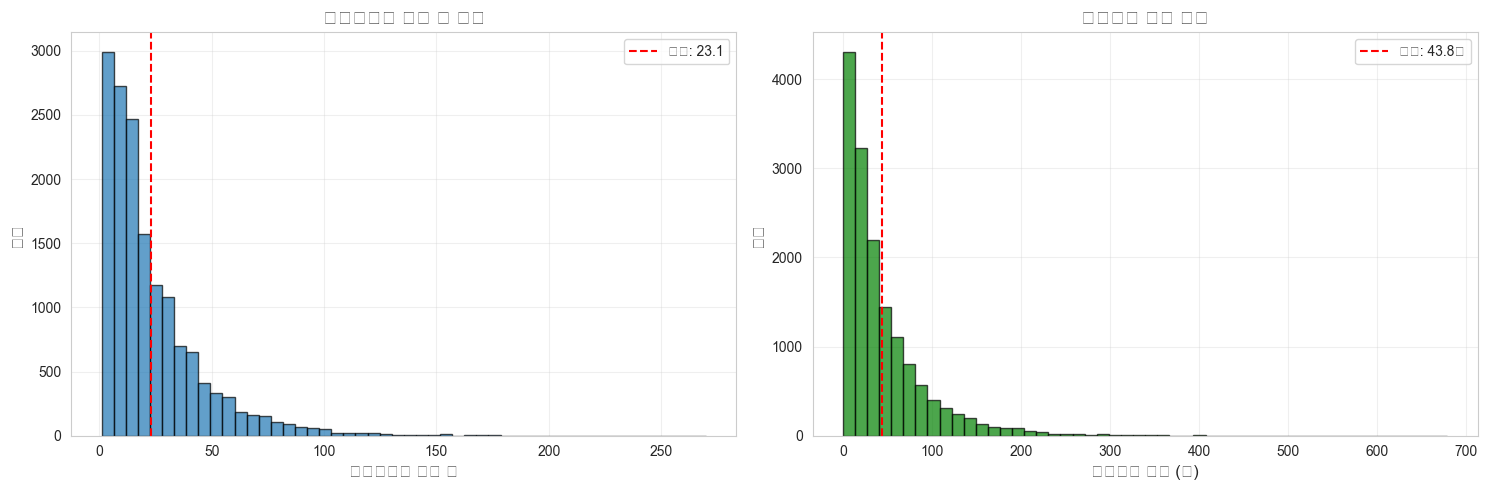

In [8]:
# 에피소드별 액션 수 분포 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 액션 수 분포
axes[0].hist(episode_stats['총_액션수'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('에피소드당 액션 수', fontsize=12)
axes[0].set_ylabel('빈도', fontsize=12)
axes[0].set_title('에피소드별 액션 수 분포', fontsize=14, fontweight='bold')
axes[0].axvline(episode_stats['총_액션수'].mean(), color='red', linestyle='--', 
                label=f'평균: {episode_stats["총_액션수"].mean():.1f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 에피소드 길이 분포
axes[1].hist(episode_stats['에피소드길이(초)'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].set_xlabel('에피소드 길이 (초)', fontsize=12)
axes[1].set_ylabel('빈도', fontsize=12)
axes[1].set_title('에피소드 길이 분포', fontsize=14, fontweight='bold')
axes[1].axvline(episode_stats['에피소드길이(초)'].mean(), color='red', linestyle='--',
                label=f'평균: {episode_stats["에피소드길이(초)"].mean():.1f}초')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 4.2 액션 타입 분석

In [9]:
print("=" * 80)
print("액션 타입 분석")
print("=" * 80)

# 액션 타입 분포
action_type_counts = train_df['type_name'].value_counts()
action_type_pct = (action_type_counts / len(train_df) * 100).round(2)

action_type_df = pd.DataFrame({
    '액션타입': action_type_counts.index,
    '개수': action_type_counts.values,
    '비율(%)': action_type_pct.values
})

print("\n[액션 타입 분포]")
display(action_type_df)

# 결과 타입 분포 (result_name이 있는 경우)
if train_df['result_name'].notna().any():
    print("\n[결과 타입 분포]")
    result_counts = train_df['result_name'].value_counts()
    result_pct = (result_counts / train_df['result_name'].notna().sum() * 100).round(2)
    
    result_df = pd.DataFrame({
        '결과타입': result_counts.index,
        '개수': result_counts.values,
        '비율(%)': result_pct.values
    })
    display(result_df)

액션 타입 분석

[액션 타입 분포]


,액션타입,개수,비율(%)
0,Pass,178582,50.06
1,Carry,82046,23.00
2,Recovery,27352,7.67
3,Interception,11088,3.11
4,Duel,8734,2.45
5,Tackle,8138,2.28
6,Throw-In,6801,1.91
7,Clearance,6563,1.84
8,Intervention,6038,1.69
9,Block,3983,1.12



[결과 타입 분포]


,결과타입,개수,비율(%)
0,Successful,178537,82.48
1,Unsuccessful,36446,16.84
2,On Target,692,0.32
3,Blocked,635,0.29
4,Low Quality Shot,71,0.03
5,Off Target,48,0.02
6,Yellow_Card,26,0.01
7,Keeper Rush-Out,12,0.01


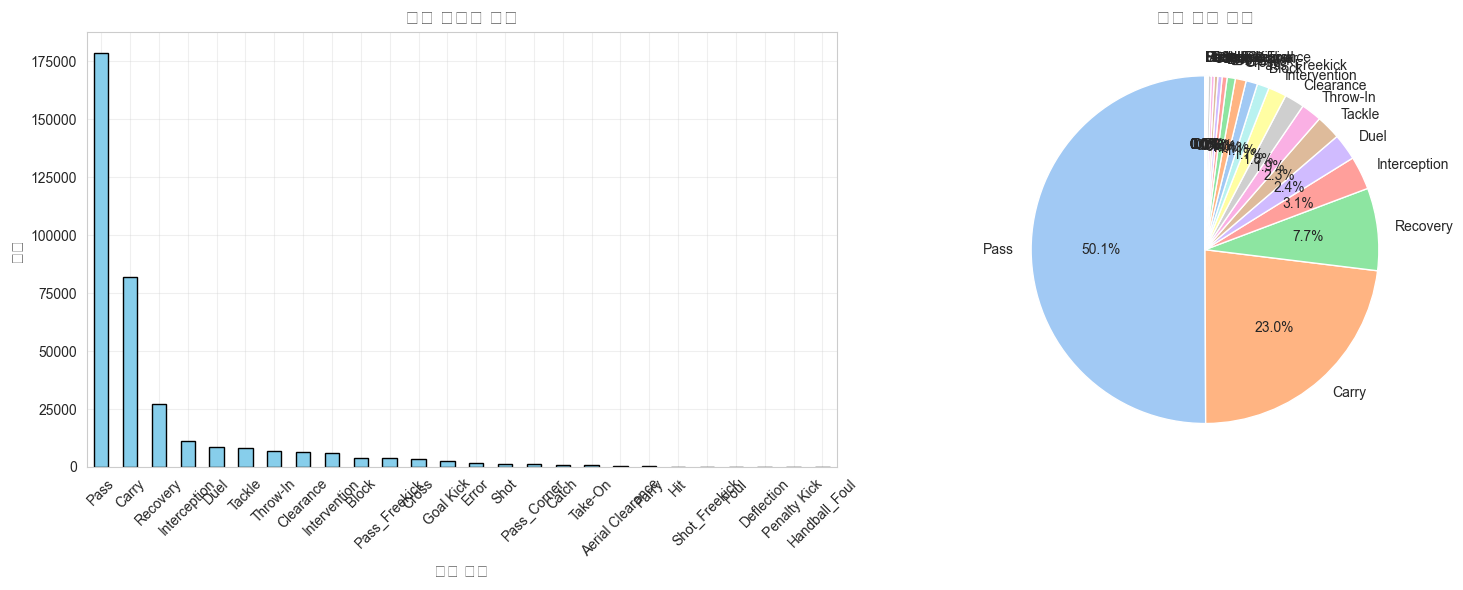

In [10]:
# 액션 타입 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 액션 타입 막대 그래프
action_type_counts.plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('액션 타입별 빈도', fontsize=14, fontweight='bold')
axes[0].set_xlabel('액션 타입', fontsize=12)
axes[0].set_ylabel('빈도', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

# 액션 타입 파이 차트
axes[1].pie(action_type_counts.values, labels=action_type_counts.index, autopct='%1.1f%%',
            startangle=90, colors=sns.color_palette('pastel'))
axes[1].set_title('액션 타입 비율', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### 4.3 패스 성공률 분석

In [11]:
print("=" * 80)
print("패스 성공률 분석")
print("=" * 80)

# 패스 데이터만 필터링
pass_df = train_df[train_df['type_name'] == 'Pass'].copy()

if len(pass_df) > 0:
    # 전체 패스 성공률
    total_passes = len(pass_df)
    successful_passes = len(pass_df[pass_df['result_name'] == 'Successful'])
    pass_success_rate = (successful_passes / total_passes * 100)
    
    print(f"\n총 패스 수: {total_passes:,}")
    print(f"성공한 패스: {successful_passes:,}")
    print(f"패스 성공률: {pass_success_rate:.2f}%")
    
    # 결과별 분포
    print("\n[패스 결과 분포]")
    pass_result_counts = pass_df['result_name'].value_counts()
    display(pd.DataFrame({
        '결과': pass_result_counts.index,
        '개수': pass_result_counts.values,
        '비율(%)': (pass_result_counts / total_passes * 100).round(2).values
    }))

패스 성공률 분석

총 패스 수: 178,582
성공한 패스: 154,195
패스 성공률: 86.34%

[패스 결과 분포]


,결과,개수,비율(%)
0,Successful,154195,86.34
1,Unsuccessful,24387,13.66


## 5. 좌표 데이터 분석

### 5.1 좌표 분포 기본 통계

In [12]:
print("=" * 80)
print("좌표 데이터 기본 통계")
print("=" * 80)

coord_cols = ['start_x', 'start_y', 'end_x', 'end_y']
print("\n[좌표 통계량]")
display(train_df[coord_cols].describe())

print("\n📌 경기장 규격: 105 x 68 (FIFA 공식 권장)")
print(f"   X 좌표 범위: 0 ~ 105")
print(f"   Y 좌표 범위: 0 ~ 68")

좌표 데이터 기본 통계

[좌표 통계량]


,start_x,start_y,end_x,end_y
count,356721.000000,356721.000000,356721.000000,356721.000000
mean,47.259486,34.150991,51.038351,34.127722
std,23.813701,19.800665,24.291506,19.718240
min,0.000000,0.000000,0.000000,0.000000
25%,29.758365,17.105876,33.516630,16.964164
50%,46.978890,34.265880,50.349495,34.264724
75%,64.429260,51.243304,68.994765,51.257244
max,105.000000,68.000000,105.000000,68.000000



📌 경기장 규격: 105 x 68 (FIFA 공식 권장)
   X 좌표 범위: 0 ~ 105
   Y 좌표 범위: 0 ~ 68


### 5.2 좌표 분포 시각화

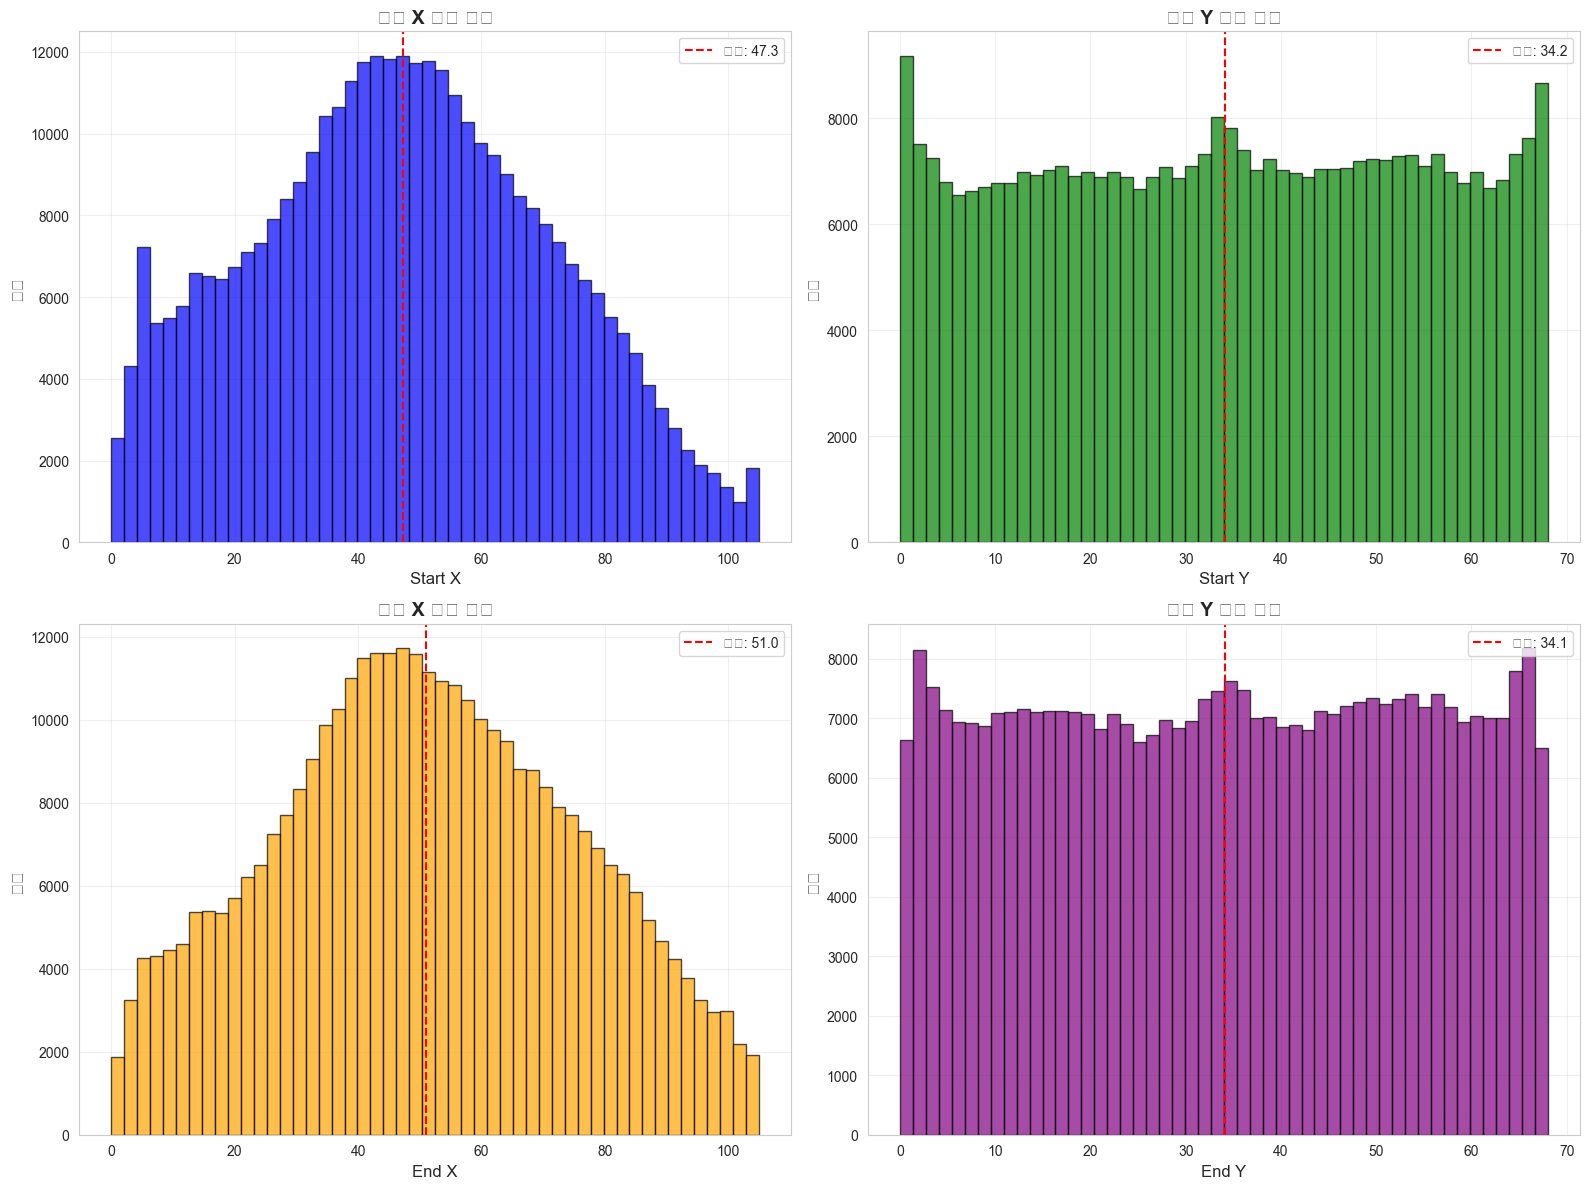

In [13]:
# 좌표 분포 히스토그램
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# start_x
axes[0, 0].hist(train_df['start_x'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='blue')
axes[0, 0].set_xlabel('Start X', fontsize=12)
axes[0, 0].set_ylabel('빈도', fontsize=12)
axes[0, 0].set_title('시작 X 좌표 분포', fontsize=14, fontweight='bold')
axes[0, 0].axvline(train_df['start_x'].mean(), color='red', linestyle='--', label=f'평균: {train_df["start_x"].mean():.1f}')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# start_y
axes[0, 1].hist(train_df['start_y'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_xlabel('Start Y', fontsize=12)
axes[0, 1].set_ylabel('빈도', fontsize=12)
axes[0, 1].set_title('시작 Y 좌표 분포', fontsize=14, fontweight='bold')
axes[0, 1].axvline(train_df['start_y'].mean(), color='red', linestyle='--', label=f'평균: {train_df["start_y"].mean():.1f}')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# end_x
axes[1, 0].hist(train_df['end_x'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1, 0].set_xlabel('End X', fontsize=12)
axes[1, 0].set_ylabel('빈도', fontsize=12)
axes[1, 0].set_title('종료 X 좌표 분포', fontsize=14, fontweight='bold')
axes[1, 0].axvline(train_df['end_x'].mean(), color='red', linestyle='--', label=f'평균: {train_df["end_x"].mean():.1f}')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# end_y
axes[1, 1].hist(train_df['end_y'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='purple')
axes[1, 1].set_xlabel('End Y', fontsize=12)
axes[1, 1].set_ylabel('빈도', fontsize=12)
axes[1, 1].set_title('종료 Y 좌표 분포', fontsize=14, fontweight='bold')
axes[1, 1].axvline(train_df['end_y'].mean(), color='red', linestyle='--', label=f'평균: {train_df["end_y"].mean():.1f}')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 5.3 최종 패스 좌표 분석 (타겟 변수)

In [14]:
print("=" * 80)
print("최종 패스 좌표 분석 (예측 타겟)")
print("=" * 80)

# 각 에피소드의 마지막 액션 추출
last_actions = train_df.groupby('game_episode').last().reset_index()

print(f"\n총 에피소드 수: {len(last_actions):,}")
print("\n[최종 패스 좌표 통계]")
display(last_actions[['end_x', 'end_y']].describe())

# 최종 액션 타입 분포
print("\n[최종 액션 타입 분포]")
last_action_types = last_actions['type_name'].value_counts()
display(pd.DataFrame({
    '액션타입': last_action_types.index,
    '개수': last_action_types.values,
    '비율(%)': (last_action_types / len(last_actions) * 100).round(2).values
}))

최종 패스 좌표 분석 (예측 타겟)

총 에피소드 수: 15,435

[최종 패스 좌표 통계]


,end_x,end_y
count,15435.000000,15435.000000
mean,68.451987,33.617185
std,23.853429,24.346776
min,0.000000,0.000000
25%,51.964920,9.142022
50%,73.526985,33.113008
75%,87.609008,58.079412
max,105.000000,68.000000



[최종 액션 타입 분포]


,액션타입,개수,비율(%)
0,Pass,15435,100.0


### 5.4 경기장 히트맵 - 최종 패스 도착 위치

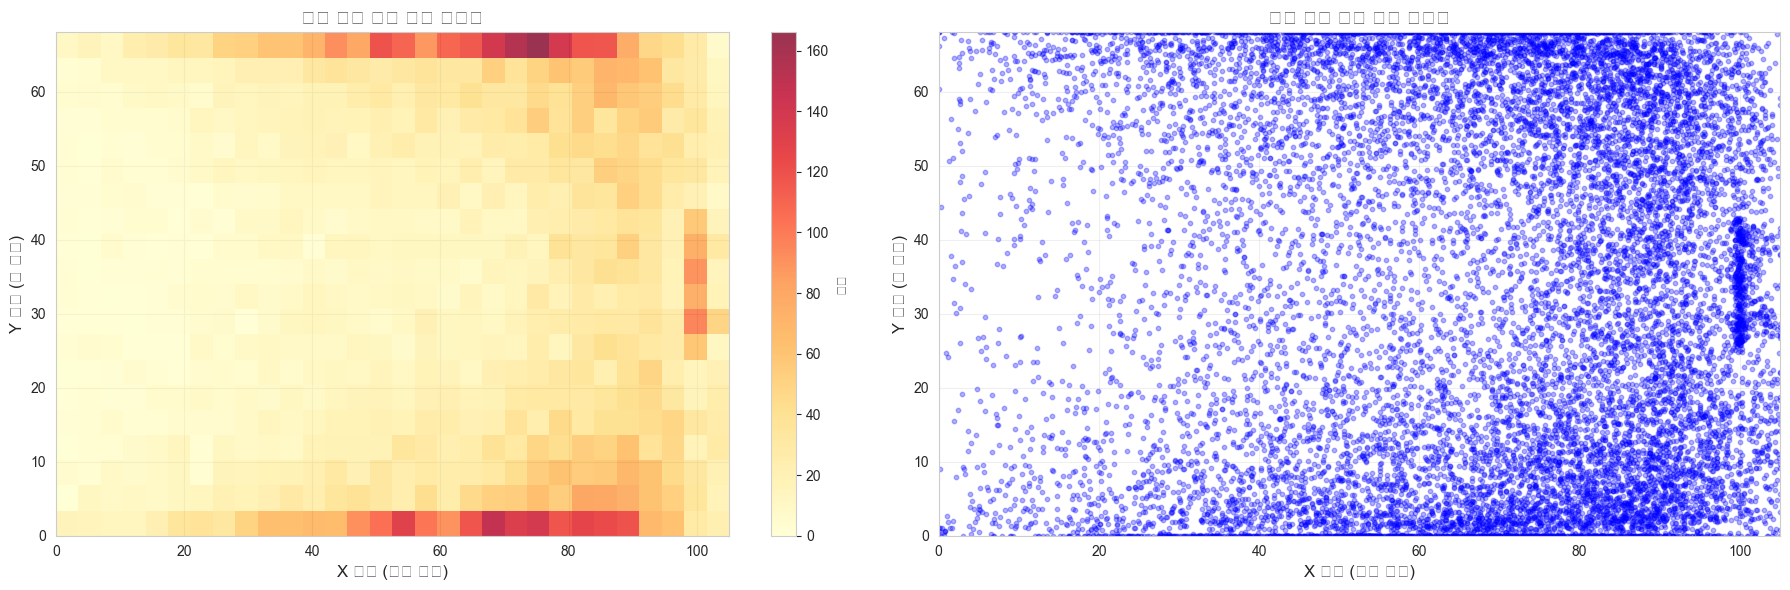

In [15]:
# 최종 패스 위치 히트맵
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 2D 히스토그램 (히트맵)
h = axes[0].hist2d(last_actions['end_x'].dropna(), last_actions['end_y'].dropna(), 
                    bins=[30, 20], cmap='YlOrRd', alpha=0.8)
axes[0].set_xlabel('X 좌표 (길이 방향)', fontsize=12)
axes[0].set_ylabel('Y 좌표 (폭 방향)', fontsize=12)
axes[0].set_title('최종 패스 도착 위치 히트맵', fontsize=14, fontweight='bold')
axes[0].set_xlim(0, 105)
axes[0].set_ylim(0, 68)
plt.colorbar(h[3], ax=axes[0], label='빈도')

# 산점도
axes[1].scatter(last_actions['end_x'].dropna(), last_actions['end_y'].dropna(), 
                alpha=0.3, s=10, color='blue')
axes[1].set_xlabel('X 좌표 (길이 방향)', fontsize=12)
axes[1].set_ylabel('Y 좌표 (폭 방향)', fontsize=12)
axes[1].set_title('최종 패스 도착 위치 산점도', fontsize=14, fontweight='bold')
axes[1].set_xlim(0, 105)
axes[1].set_ylim(0, 68)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. 패스 거리 및 방향 분석

In [16]:
print("=" * 80)
print("패스 거리 및 방향 분석")
print("=" * 80)

# 패스 거리 계산 (유클리드 거리)
pass_data = train_df[train_df['type_name'] == 'Pass'].copy()
pass_data['pass_distance'] = np.sqrt(
    (pass_data['end_x'] - pass_data['start_x'])**2 + 
    (pass_data['end_y'] - pass_data['start_y'])**2
)

# 패스 방향 (각도)
pass_data['pass_angle'] = np.arctan2(
    pass_data['end_y'] - pass_data['start_y'],
    pass_data['end_x'] - pass_data['start_x']
) * 180 / np.pi

# X, Y 방향 변화
pass_data['delta_x'] = pass_data['end_x'] - pass_data['start_x']
pass_data['delta_y'] = pass_data['end_y'] - pass_data['start_y']

print("\n[패스 거리 통계]")
display(pass_data['pass_distance'].describe())

print("\n[패스 방향 통계 (각도)]")
display(pass_data['pass_angle'].describe())

패스 거리 및 방향 분석

[패스 거리 통계]


count    178582.000000
mean         16.841951
std          10.830195
min           0.000000
25%           9.532254
50%          14.306321
75%          21.129116
max          93.899168
Name: pass_distance, dtype: float64


[패스 방향 통계 (각도)]


count    178582.000000
mean         -0.638135
std          92.340096
min        -179.998084
25%         -75.951674
50%           0.081347
75%          73.501359
max         180.000000
Name: pass_angle, dtype: float64

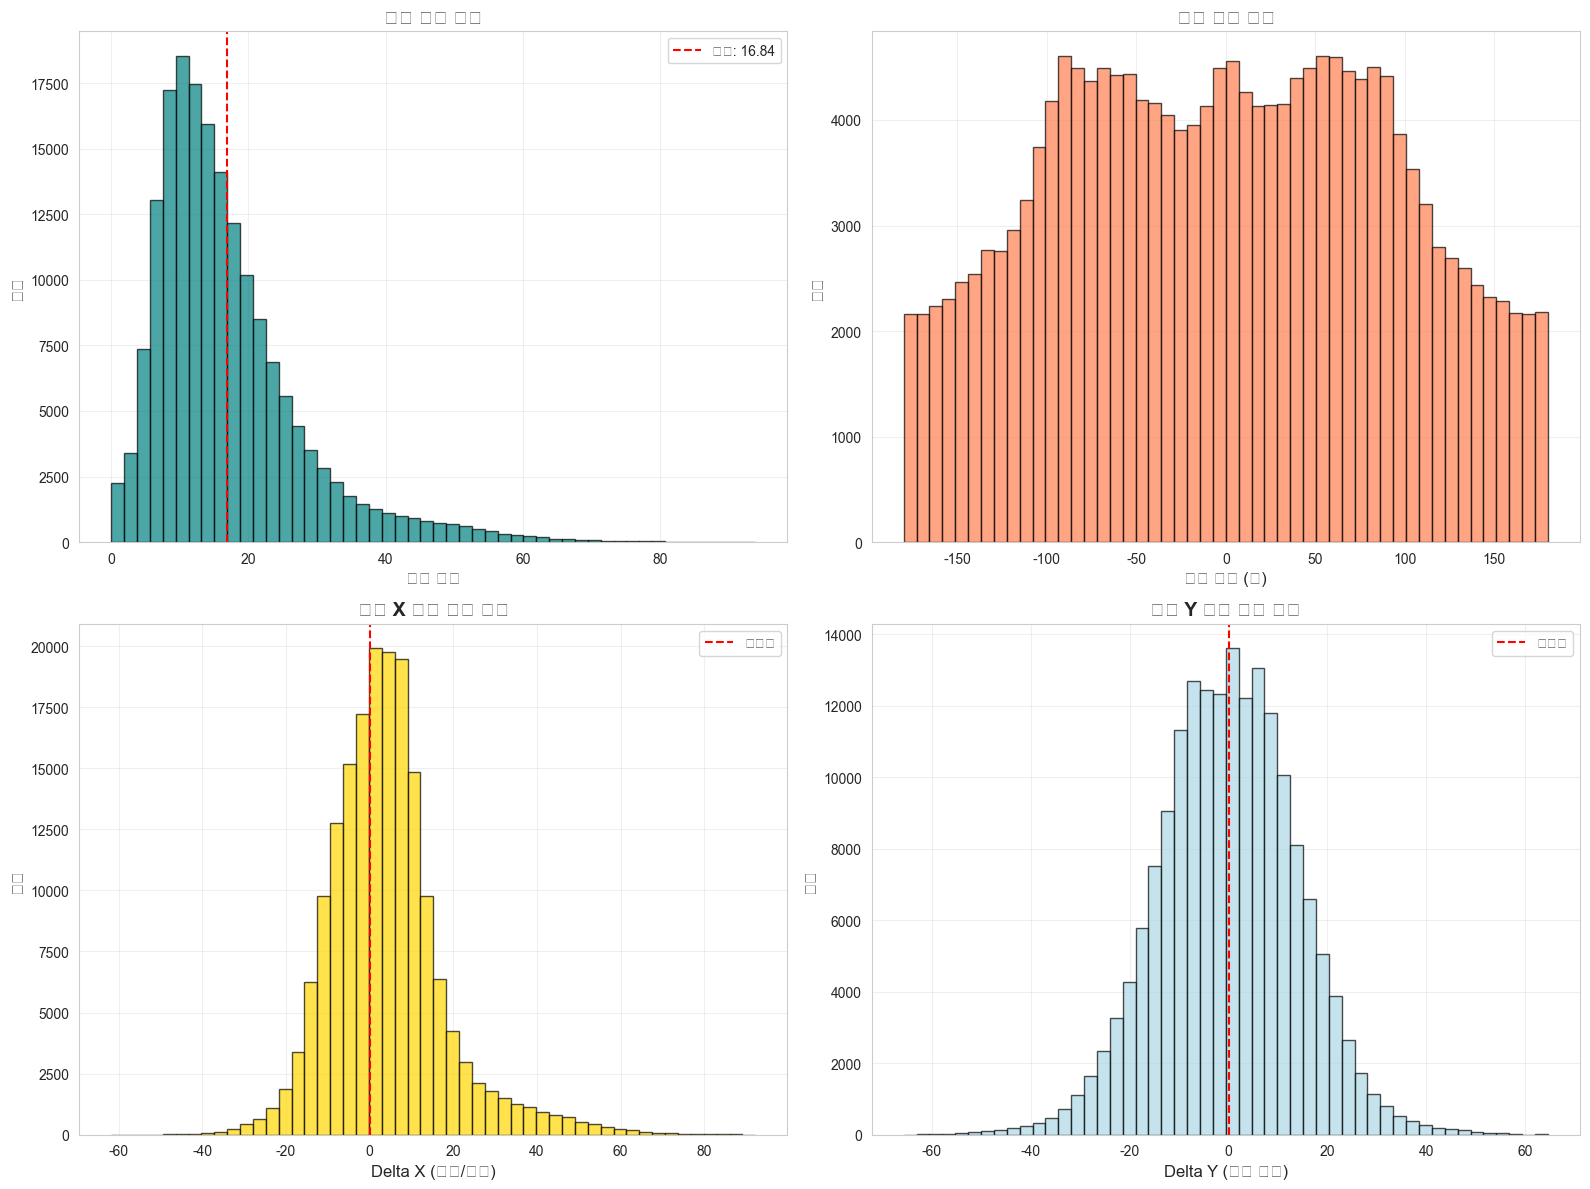

In [17]:
# 패스 거리 및 방향 시각화
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 패스 거리 분포
axes[0, 0].hist(pass_data['pass_distance'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='teal')
axes[0, 0].set_xlabel('패스 거리', fontsize=12)
axes[0, 0].set_ylabel('빈도', fontsize=12)
axes[0, 0].set_title('패스 거리 분포', fontsize=14, fontweight='bold')
axes[0, 0].axvline(pass_data['pass_distance'].mean(), color='red', linestyle='--',
                   label=f'평균: {pass_data["pass_distance"].mean():.2f}')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 패스 각도 분포
axes[0, 1].hist(pass_data['pass_angle'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[0, 1].set_xlabel('패스 각도 (도)', fontsize=12)
axes[0, 1].set_ylabel('빈도', fontsize=12)
axes[0, 1].set_title('패스 방향 분포', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Delta X 분포
axes[1, 0].hist(pass_data['delta_x'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='gold')
axes[1, 0].set_xlabel('Delta X (전진/후진)', fontsize=12)
axes[1, 0].set_ylabel('빈도', fontsize=12)
axes[1, 0].set_title('패스 X 방향 변화 분포', fontsize=14, fontweight='bold')
axes[1, 0].axvline(0, color='red', linestyle='--', label='중앙선')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Delta Y 분포
axes[1, 1].hist(pass_data['delta_y'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='lightblue')
axes[1, 1].set_xlabel('Delta Y (좌우 이동)', fontsize=12)
axes[1, 1].set_ylabel('빈도', fontsize=12)
axes[1, 1].set_title('패스 Y 방향 변화 분포', fontsize=14, fontweight='bold')
axes[1, 1].axvline(0, color='red', linestyle='--', label='중앙선')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. 경기 및 팀 분석

### 7.1 경기별 통계

In [18]:
print("=" * 80)
print("경기별 기본 통계")
print("=" * 80)

game_stats = train_df.groupby('game_id').agg({
    'episode_id': 'nunique',
    'action_id': 'count',
    'player_id': 'nunique',
    'team_id': 'nunique'
}).reset_index()

game_stats.columns = ['game_id', '에피소드수', '총액션수', '선수수', '팀수']

print(f"\n총 경기 수: {len(game_stats)}")
print("\n[경기별 통계]")
display(game_stats.describe())

print("\n[상위 5개 경기 - 에피소드 수 기준]")
display(game_stats.nlargest(5, '에피소드수'))

경기별 기본 통계

총 경기 수: 198

[경기별 통계]


,game_id,에피소드수,총액션수,선수수,팀수
count,198.000000,198.000000,198.000000,198.000000,198.0
mean,126381.500000,77.954545,1801.621212,31.161616,2.0
std,57.301832,9.204554,125.666237,1.073039,0.0
min,126283.000000,58.000000,1455.000000,27.000000,2.0
25%,126332.250000,71.000000,1701.500000,31.000000,2.0
50%,126381.500000,78.000000,1806.000000,31.000000,2.0
75%,126430.750000,84.000000,1891.250000,32.000000,2.0
max,126480.000000,110.000000,2153.000000,32.000000,2.0



[상위 5개 경기 - 에피소드 수 기준]


,game_id,에피소드수,총액션수,선수수,팀수
31,126314,110,1916,32,2
28,126311,103,1592,32,2
110,126393,100,1646,31,2
178,126461,100,1747,32,2
14,126297,96,1799,29,2


### 7.2 팀 및 선수 분석

In [19]:
print("=" * 80)
print("팀 및 선수 분석")
print("=" * 80)

print(f"\n총 팀 수: {train_df['team_id'].nunique()}")
print(f"총 선수 수: {train_df['player_id'].nunique()}")

# 팀별 액션 수
team_actions = train_df['team_id'].value_counts().head(10)
print("\n[상위 10개 팀 - 액션 수 기준]")
display(pd.DataFrame({
    'team_id': team_actions.index,
    '액션수': team_actions.values
}))

# 선수별 액션 수
player_actions = train_df['player_id'].value_counts().head(10)
print("\n[상위 10명 선수 - 액션 수 기준]")
display(pd.DataFrame({
    'player_id': player_actions.index,
    '액션수': player_actions.values
}))

팀 및 선수 분석

총 팀 수: 12
총 선수 수: 446

[상위 10개 팀 - 액션 수 기준]


,team_id,액션수
0,2354,32954
1,4648,32164
2,316,30756
3,4639,30529
4,4220,30139
5,4643,29619
6,4646,29457
7,2353,29400
8,4640,28867
9,4657,28070



[상위 10명 선수 - 액션 수 기준]


,player_id,액션수
0,500115,3668
1,500569,3667
2,250101,3561
3,345446,3322
4,500140,3060
5,500452,3054
6,354812,3038
7,491810,2999
8,344467,2990
9,500126,2917


### 7.3 홈/원정 분석

In [20]:
print("=" * 80)
print("홈/원정 분석")
print("=" * 80)

home_away_stats = train_df.groupby('is_home').agg({
    'action_id': 'count',
    'game_id': 'nunique',
    'episode_id': 'nunique'
}).reset_index()

home_away_stats.columns = ['is_home', '총액션수', '경기수', '에피소드수']
home_away_stats['is_home'] = home_away_stats['is_home'].map({True: '홈', False: '원정'})

display(home_away_stats)

홈/원정 분석


,is_home,총액션수,경기수,에피소드수
0,원정,177336,198,129
1,홈,179385,198,128


## 8. 시간대별 분석

시간대별 분석

[전반/후반별 통계]


,period_id,총액션수,에피소드수,최소시간,최대시간
0,1,178714,64,0.0,3614.467
1,2,178007,104,0.0,3607.633


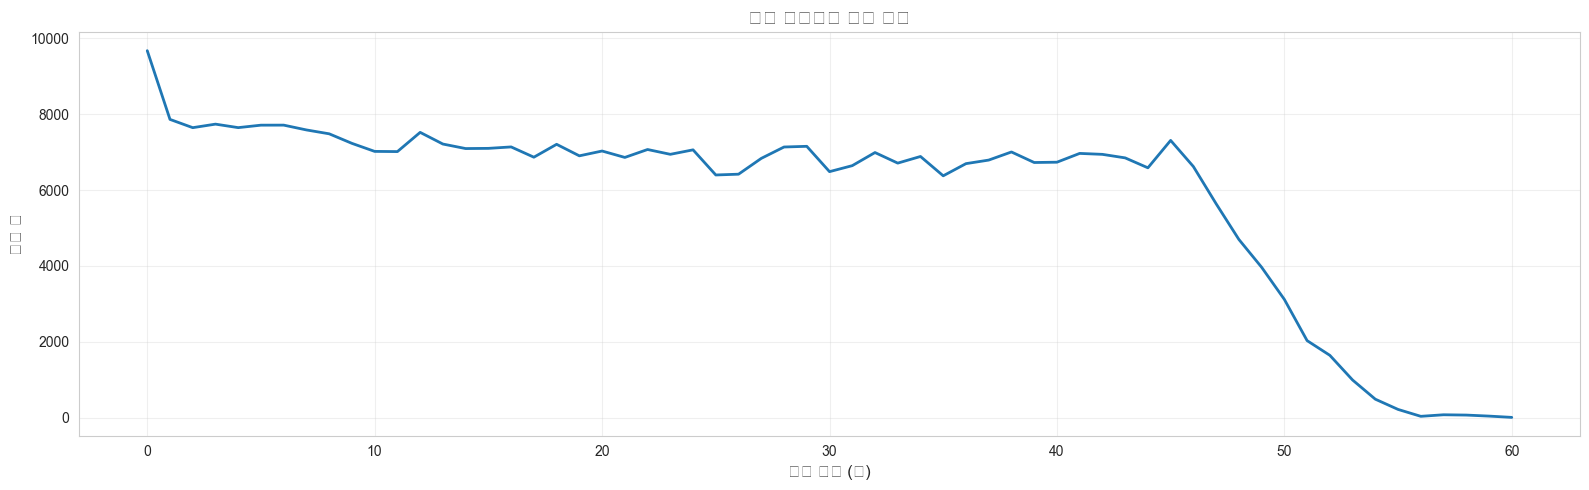

In [21]:
print("=" * 80)
print("시간대별 분석")
print("=" * 80)

# 전반/후반 분석
period_stats = train_df.groupby('period_id').agg({
    'action_id': 'count',
    'episode_id': 'nunique',
    'time_seconds': ['min', 'max']
}).reset_index()

period_stats.columns = ['period_id', '총액션수', '에피소드수', '최소시간', '최대시간']

print("\n[전반/후반별 통계]")
display(period_stats)

# 시간대별 액션 분포
train_df['time_minute'] = (train_df['time_seconds'] / 60).astype(int)

time_dist = train_df.groupby('time_minute').size()

plt.figure(figsize=(16, 5))
plt.plot(time_dist.index, time_dist.values, linewidth=2)
plt.xlabel('경기 시간 (분)', fontsize=12)
plt.ylabel('액션 수', fontsize=12)
plt.title('경기 시간대별 액션 분포', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 9. 에피소드 샘플 상세 분석

In [22]:
print("=" * 80)
print("샘플 에피소드 상세 분석")
print("=" * 80)

# 랜덤 에피소드 선택
sample_episode = train_df['game_episode'].iloc[0]
sample_data = train_df[train_df['game_episode'] == sample_episode].copy()

print(f"\n선택된 에피소드: {sample_episode}")
print(f"총 액션 수: {len(sample_data)}")
print(f"경과 시간: {sample_data['time_seconds'].min():.2f}초 ~ {sample_data['time_seconds'].max():.2f}초")

print("\n[에피소드 액션 시퀀스]")
display(sample_data[['action_id', 'time_seconds', 'type_name', 'result_name', 
                      'start_x', 'start_y', 'end_x', 'end_y']])

샘플 에피소드 상세 분석

선택된 에피소드: 126283_1
총 액션 수: 49
경과 시간: 0.67초 ~ 124.37초

[에피소드 액션 시퀀스]


,action_id,time_seconds,type_name,result_name,start_x,start_y,end_x,end_y
0,0,0.6670,Pass,Successful,52.418205,33.485444,31.322445,38.274752
1,2,3.6670,Pass,Successful,32.013240,38.100808,37.371285,30.632980
2,4,4.9680,Carry,NaN,37.371285,30.632980,38.391570,24.613144
3,5,8.2000,Pass,Successful,38.391570,24.613144,34.573350,5.545468
4,7,11.6330,Pass,Successful,34.578705,6.058256,21.274470,18.437112
5,9,13.2010,Carry,NaN,21.274470,18.437112,28.862295,24.320336
6,10,18.9000,Pass,Successful,28.862295,24.320336,26.569410,35.190204
7,12,19.9680,Carry,NaN,26.569410,35.190204,35.039130,34.624580
8,13,25.9330,Pass,Successful,35.039130,34.624580,33.001500,18.885028
9,15,29.7670,Pass,Successful,35.220780,19.540344,35.104335,33.618112


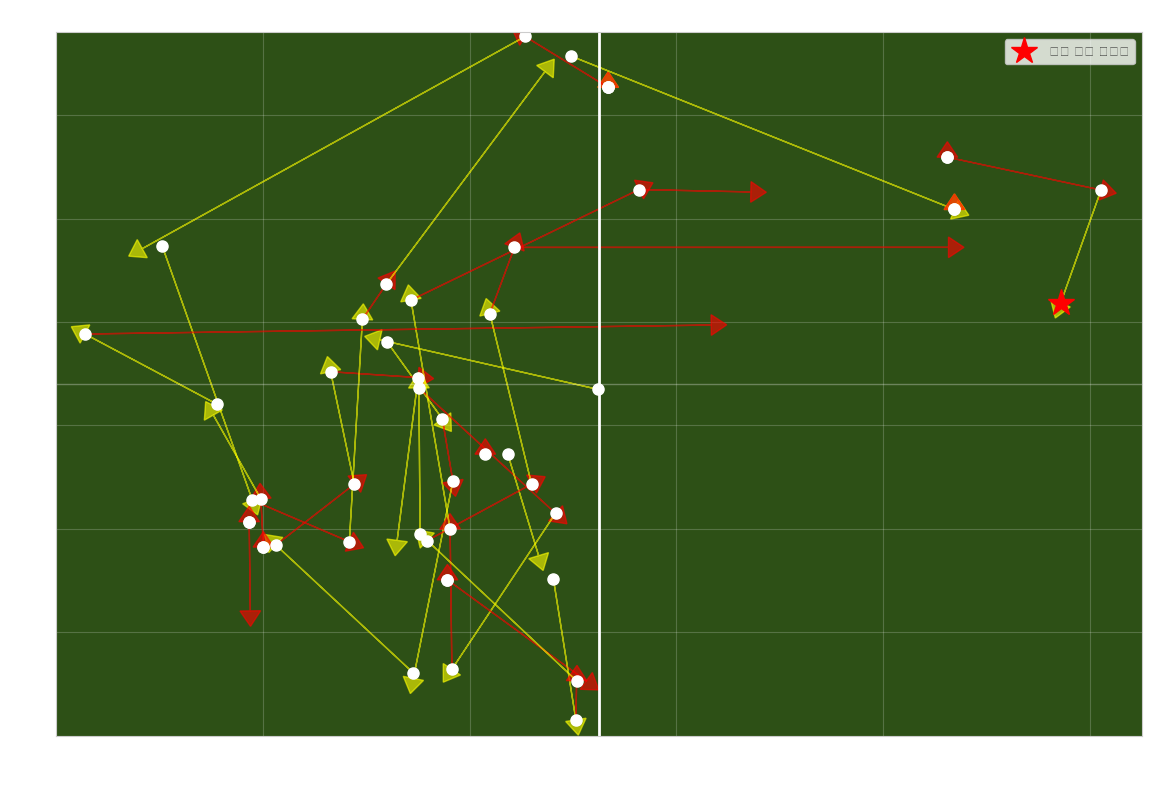

In [23]:
# 샘플 에피소드 경로 시각화
fig, ax = plt.subplots(figsize=(14, 8))

# 경기장 그리기
ax.set_xlim(0, 105)
ax.set_ylim(0, 68)
ax.set_aspect('equal')
ax.set_facecolor('#2d5016')  # 잔디색

# 중앙선
ax.plot([52.5, 52.5], [0, 68], 'white', linewidth=2)
ax.plot([0, 105], [34, 34], 'white', linewidth=1, alpha=0.3)

# 패스 경로 그리기
for idx, row in sample_data.iterrows():
    if pd.notna(row['end_x']) and pd.notna(row['end_y']):
        color = 'yellow' if row['result_name'] == 'Successful' else 'red'
        ax.arrow(row['start_x'], row['start_y'], 
                row['end_x'] - row['start_x'], 
                row['end_y'] - row['start_y'],
                head_width=2, head_length=1.5, fc=color, ec=color, alpha=0.6)
        ax.plot(row['start_x'], row['start_y'], 'wo', markersize=8)

# 최종 위치 강조
last_row = sample_data.iloc[-1]
ax.plot(last_row['end_x'], last_row['end_y'], 'r*', markersize=20, label='최종 패스 도착지')

ax.set_xlabel('X 좌표 (길이 방향)', fontsize=12, color='white')
ax.set_ylabel('Y 좌표 (폭 방향)', fontsize=12, color='white')
ax.set_title(f'에피소드 {sample_episode} - 플레이 시퀀스', fontsize=14, fontweight='bold', color='white')
ax.tick_params(colors='white')
ax.legend()
ax.grid(True, alpha=0.2, color='white')

plt.tight_layout()
plt.show()

## 10. Train vs Test 비교

In [24]:
print("=" * 80)
print("Train vs Test 데이터 비교")
print("=" * 80)

print(f"\nTrain 에피소드 수: {train_df['game_episode'].nunique():,}")
print(f"Test 에피소드 수: {len(test_df):,}")

print(f"\nTrain 경기 수: {train_df['game_id'].nunique():,}")
print(f"Test 경기 수: {test_df['game_id'].nunique():,}")

# 테스트 데이터 샘플 읽기
test_sample_files = test_df['path'].head(3)
test_samples = []

for path in test_sample_files:
    file_path = DATA_PATH / path.replace('./', '')
    test_samples.append(pd.read_csv(file_path))

test_combined = pd.concat(test_samples, ignore_index=True)

print("\n[테스트 샘플 데이터 통계]")
print(f"샘플 크기: {len(test_combined)}")
print(f"컬럼: {list(test_combined.columns)}")

# 컬럼 비교
train_cols = set(train_df.columns)
test_cols = set(test_combined.columns)

print("\n[컬럼 비교]")
print(f"Train 전용 컬럼: {train_cols - test_cols}")
print(f"Test 전용 컬럼: {test_cols - train_cols}")
print(f"공통 컬럼: {train_cols & test_cols}")

Train vs Test 데이터 비교

Train 에피소드 수: 15,435
Test 에피소드 수: 2,414

Train 경기 수: 198
Test 경기 수: 30

[테스트 샘플 데이터 통계]
샘플 크기: 65
컬럼: ['game_id', 'period_id', 'episode_id', 'time_seconds', 'team_id', 'player_id', 'action_id', 'type_name', 'result_name', 'start_x', 'start_y', 'end_x', 'end_y', 'is_home', 'game_episode']

[컬럼 비교]
Train 전용 컬럼: {'time_minute'}
Test 전용 컬럼: set()
공통 컬럼: {'end_y', 'start_y', 'period_id', 'result_name', 'time_seconds', 'player_id', 'end_x', 'is_home', 'game_episode', 'game_id', 'team_id', 'start_x', 'episode_id', 'action_id', 'type_name'}


## 11. 주요 인사이트 및 결론

### 11.1 핵심 발견 사항

In [25]:
print("=" * 80)
print("주요 인사이트 요약")
print("=" * 80)

insights = f"""
📊 데이터 규모
- 총 학습 데이터: {len(train_df):,} 액션
- 총 에피소드: {train_df['game_episode'].nunique():,}
- 총 경기: {train_df['game_id'].nunique():,}
- 총 선수: {train_df['player_id'].nunique():,}

🎯 타겟 변수 (최종 패스 좌표)
- X 좌표 평균: {last_actions['end_x'].mean():.2f}
- Y 좌표 평균: {last_actions['end_y'].mean():.2f}
- X 좌표 표준편차: {last_actions['end_x'].std():.2f}
- Y 좌표 표준편차: {last_actions['end_y'].std():.2f}

⚽ 에피소드 특성
- 평균 에피소드 액션 수: {episode_stats['총_액션수'].mean():.2f}
- 평균 에피소드 길이: {episode_stats['에피소드길이(초)'].mean():.2f}초
- 최대 액션 수: {episode_stats['총_액션수'].max()}
- 최소 액션 수: {episode_stats['총_액션수'].min()}

🔄 액션 분석
- 가장 많은 액션 타입: {train_df['type_name'].value_counts().index[0]} ({train_df['type_name'].value_counts().values[0]:,}회)
- 패스 성공률: {pass_success_rate:.2f}%
- 평균 패스 거리: {pass_data['pass_distance'].mean():.2f}

💡 모델링 고려사항
1. 시퀀스 데이터: 각 에피소드는 시간순 액션 시퀀스로 구성
2. 좌표 정규화: 경기장 크기 (105 x 68)를 고려한 정규화 필요
3. 맥락 정보: 이전 액션들의 패턴이 다음 패스 위치에 영향
4. 팀/선수 특성: 팀 전술과 선수 개인 특성 반영 가능
5. 시간 정보: 경기 시간대별 플레이 패턴 차이 존재
"""

print(insights)

주요 인사이트 요약

📊 데이터 규모
- 총 학습 데이터: 356,721 액션
- 총 에피소드: 15,435
- 총 경기: 198
- 총 선수: 446

🎯 타겟 변수 (최종 패스 좌표)
- X 좌표 평균: 68.45
- Y 좌표 평균: 33.62
- X 좌표 표준편차: 23.85
- Y 좌표 표준편차: 24.35

⚽ 에피소드 특성
- 평균 에피소드 액션 수: 23.11
- 평균 에피소드 길이: 43.77초
- 최대 액션 수: 270
- 최소 액션 수: 1

🔄 액션 분석
- 가장 많은 액션 타입: Pass (178,582회)
- 패스 성공률: 86.34%
- 평균 패스 거리: 16.84

💡 모델링 고려사항
1. 시퀀스 데이터: 각 에피소드는 시간순 액션 시퀀스로 구성
2. 좌표 정규화: 경기장 크기 (105 x 68)를 고려한 정규화 필요
3. 맥락 정보: 이전 액션들의 패턴이 다음 패스 위치에 영향
4. 팀/선수 특성: 팀 전술과 선수 개인 특성 반영 가능
5. 시간 정보: 경기 시간대별 플레이 패턴 차이 존재



### 11.2 다음 단계 제안

In [26]:
next_steps = """
🚀 다음 단계 제안

1. 피처 엔지니어링
   - 에피소드별 통계 피처 (평균 위치, 이동 거리 등)
   - 시퀀스 피처 (이전 N개 액션의 패턴)
   - 공간 피처 (경기장 구역, 상대 골대와의 거리)
   - 시간 피처 (경기 시간대, 에피소드 경과 시간)
   - 팀/선수 임베딩

2. 모델 선택
   - LSTM/GRU: 시퀀스 패턴 학습
   - Transformer: 장거리 의존성 포착
   - XGBoost/LightGBM: 피처 기반 회귀
   - 앙상블: 여러 모델 조합

3. 검증 전략
   - 시계열 교차 검증 (경기 기준)
   - 에피소드 단위 분할
   - MAE, RMSE 등 거리 기반 메트릭

4. 추가 분석
   - 실패한 패스 vs 성공한 패스 비교
   - 경기장 구역별 패스 패턴
   - 팀별/선수별 플레이 스타일
   - 득점 상황 전후 패턴 변화
"""

print(next_steps)


🚀 다음 단계 제안

1. 피처 엔지니어링
   - 에피소드별 통계 피처 (평균 위치, 이동 거리 등)
   - 시퀀스 피처 (이전 N개 액션의 패턴)
   - 공간 피처 (경기장 구역, 상대 골대와의 거리)
   - 시간 피처 (경기 시간대, 에피소드 경과 시간)
   - 팀/선수 임베딩

2. 모델 선택
   - LSTM/GRU: 시퀀스 패턴 학습
   - Transformer: 장거리 의존성 포착
   - XGBoost/LightGBM: 피처 기반 회귀
   - 앙상블: 여러 모델 조합

3. 검증 전략
   - 시계열 교차 검증 (경기 기준)
   - 에피소드 단위 분할
   - MAE, RMSE 등 거리 기반 메트릭

4. 추가 분석
   - 실패한 패스 vs 성공한 패스 비교
   - 경기장 구역별 패스 패턴
   - 팀별/선수별 플레이 스타일
   - 득점 상황 전후 패턴 변화



## 12. 데이터 저장 (추가 분석용)

In [27]:
# 추가 분석을 위한 피처 데이터 저장
print("=" * 80)
print("분석 결과 저장")
print("=" * 80)

# 에피소드 통계 저장
episode_stats.to_csv('episode_statistics.csv', index=False, encoding='utf-8-sig')
print("✅ 에피소드 통계 저장: episode_statistics.csv")

# 최종 액션 데이터 저장
last_actions.to_csv('final_pass_data.csv', index=False, encoding='utf-8-sig')
print("✅ 최종 패스 데이터 저장: final_pass_data.csv")

# 패스 분석 데이터 저장
pass_data[['game_episode', 'pass_distance', 'pass_angle', 'delta_x', 'delta_y']].to_csv(
    'pass_analysis.csv', index=False, encoding='utf-8-sig'
)
print("✅ 패스 분석 데이터 저장: pass_analysis.csv")

print("\n모든 분석 완료!")

분석 결과 저장
✅ 에피소드 통계 저장: episode_statistics.csv
✅ 최종 패스 데이터 저장: final_pass_data.csv
✅ 패스 분석 데이터 저장: pass_analysis.csv

모든 분석 완료!
